<a href="https://colab.research.google.com/github/NoahLee99/ML-DL-studylog/blob/main/Explainable_DL_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 딥러닝으로 치매 여부를 판단하는 실험은 상당히 높은 정확도를 보이는 반면,
<br> 이 모델을 실제 의료 현장에서 사용하는 것은 쉽지 않다.
<br> 딥러닝 모델이 왜 그러한 결과를 도출했는지 설명하기가 쉽지 않기 때문이다.

* 만일 딥러닝이 왜 그런 예측과 판단을 했는지, 그 정확한 근거를 알 수 있다면 설명할 수 있을 뿐 아니라,
<br> 더 나은 만들고 데이터를 준비하는 데 도움일 많이 될 것이다.

* 이번 장에서는 설명 가능한 딥러닝 모델에 대해 공부해 보자.

# 딥러닝의 결과를 설명하는 방법

* 설명 가능한 딥러닝을 **XAI(Explainable AI)**라고도 한다.
<br> 예측의 근거를 설명해 주는 기술인 셈이다.

* 딥러닝의 결과를 설명해 주는 방법 중 현재 널리 사용되는 것은 크게 두 가지이다.
<br> *첫째*는 딥러닝의 중간 과정에서 나온 특징 맵을 이용하는 방법이다.
<Br> 이러한 방법의 대표적 사례가 **CAM(Class Activation Map)**이다.

* CNN은 입력된 2D 이미지들을 모델 학습을 위해 1차원 배열로 축소하며 발생하는 공간 정보의 손실을 해소하기 위해 사용하는 것이다.
<br> 이를 바꾸어 말하면, CNN 내부의 레이어들을 하나씩 거쳐
<br> 마지막 예측을 위한 단계까지 온 데이터들(중간 맵)은
<br> 입력 데이터의 속성을 잘 간직하고 있다는 의미이다.

* CAM은 여기서 아이디어를 얻었다.
<br> 이 데이터(중간 맵)를 1차원으로 축소시키는 Faltten 단계 전에 개입해서
<br> 그때까지 만들어진 중간 맵들을 따로 모은다.
<br> 그리고 그 중간 맵들 각각으로부터 **평균값(Global Max Pooling, GAP)(중간 맵 안에 들어 있는 모든 값의 평균)**을 뽑은 후, 이 평균값과 최종 예측 사이에서 한 번 더 학습한다.
<br> 그러면 어떤 중간 맵이 최종 결정에 큰 역할을 하는지 알려 주는 가중치를 얻게 되는데,
<br> 이 가중치를 각 중간 맵에 곱해 중요한 중간맵은 가중하고 불필요한 중간 맵은 자연스럽게 없애며
<<br> 특징 맵을 만들어 내는 것이 바로 CAM의 원리이다.

* 같은 원리이지만, 평균값을 계산하기 위해 모델의 구조를 바꿔야 하는 번거로움을 피하고자
<br> 평균값 대신 기울기를 이용하는 방법인 **그레이디언트 CAM(Gradient CAM)**도 개발되었다.

* *둘째*는 일부를 가리면서 가려진 부분이 결과에 얼마나 영향을 미치는지 계산하는
<br> **마스크 방식** 또는 **오클루전(폐쇄성 민감도(Occlusion Sensitivity))** 방식이다.

* 실습을 통해 그레이디언트 CAM 방식, 오클루전 방식을 알아 보자.

# 설명 가능한 딥러닝의 실행

In [12]:
# 라이브러리 설치 및 호출
!pip install tf-explain --upgrade

from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 데이터셋 로드
!git clone https://github.com/taehojo/data.git

fatal: destination path 'data' already exists and is not an empty directory.


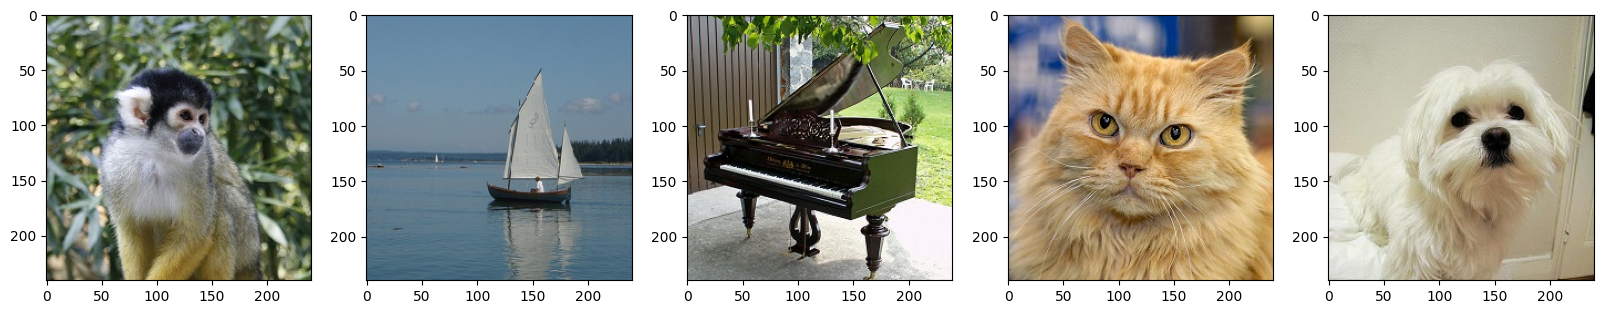

In [13]:
# 원본 이미지가 들어갈 리스트 생성
images_originals = []

# 원본 이미지가 저장된 폴더에서 하나씩 불러와 리스트에 넣기
for img_path in glob.glob('./data/img/*_0.jpg'):
    images_originals.append(mpimg.imread(img_path))

# 시각화할 이미지 크기
plt.figure(figsize=(20,20))

# 원본 이미지 시각화
for i, image_o in enumerate(images_originals):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_o)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_134']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


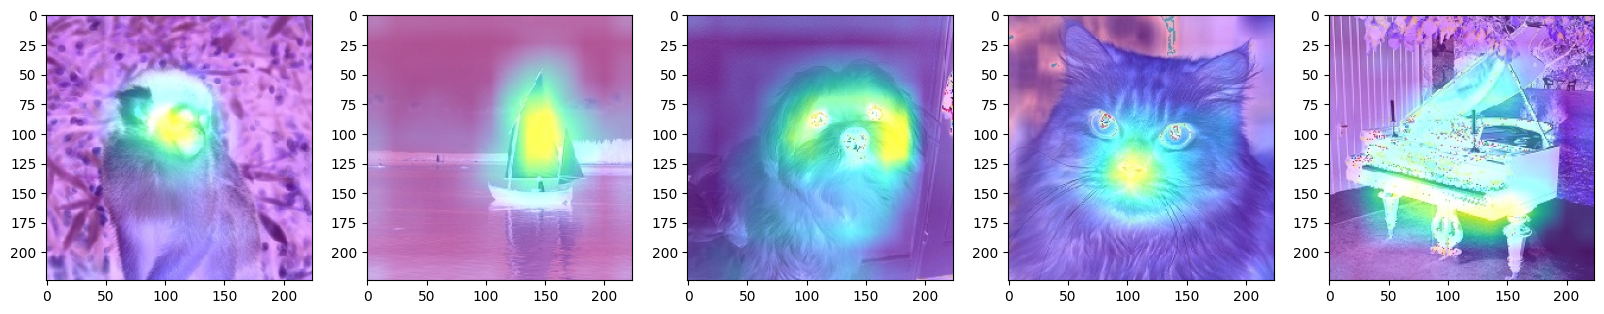

In [15]:
# 사전 학습된 imagenet 모델 사용
model = VGG16(weights="imagenet", include_top=True) # 완전한 (완전 연결층 포함)  모델 로드

# 원본 이미지 이름과 Imagenet에서의 해당 이미지 인덱스
input_list = ["squirrel_monkey", "yawl", "grand_piano", "persian_cat", "maltese"]
imagenet_index = ["382", "914", "579", "283", "153"]

# 그레이디언트 CAM 알고리즘 선택
explainer = GradCAM()

# 그레이디언트 CAM 알고리즘이 적용된 이미지가 들어갈 빈 리스트 생성
images_cams = []

# 그레이디언트 CAM 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224)) # 이미지 로드 후 내부에서 처리될 이미지의 크기 설정
    img = img_to_array(img)                                                 # 이미지를 넘파이 배열로 변환
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), layer_name='block5_conv3') # 그레이디언트 CAM이 실행되는 부분
    explainer.save(grid, ".", './data/img/{}_cam.jpg'.format(l)) # 실행 후 저장되는 이름

# 그레이디언트 CAM 알고리즘이 적용된 이미지를 로드하는 부분의 시작
for img_path in glob.glob('./data/img/*_cam.jpg'):
    images_cams.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))

for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_c)

# 출력된 결과는 이미지의 어떤 부분(특징)을 중요시해서 분류했는지를 시사함

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 


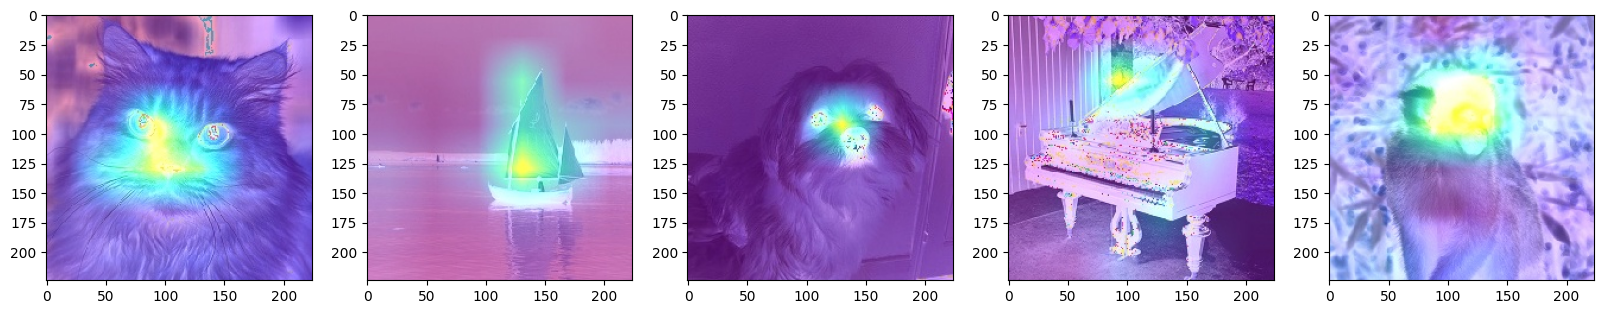

In [18]:
# 오클루전 알고리즘을 선택
explainer = OcclusionSensitivity()

# 알고리즘이 적용된 이미지가 들어갈 빈 리스트 생성
images_occ1s = []

# 패치(이미지를 가리는 마스크) 사이즈 설정
patch_size = 40

# 오클루전 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size) # 패치 사이즈 설정이 추가됨
    explainer.save(grid, ".", './data/img/{}_occ1.jpg'.format(l))

# 오클루전 알고리즘이 적용된 이미지를 불러오는 부분의 시작
for img_path in glob.glob('./data/img/*_occ1.jpg'):
    images_occ1s.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))

for i, image in enumerate(images_occ1s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


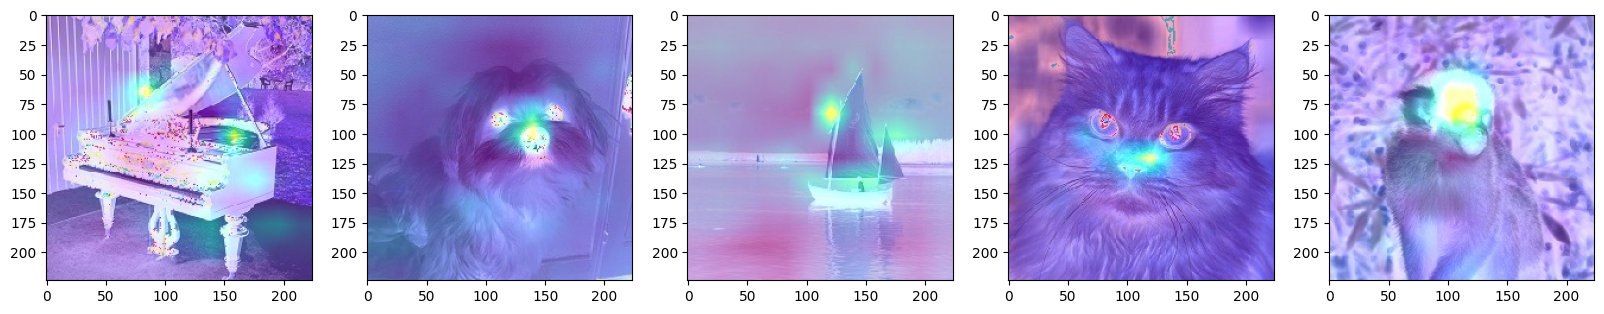

In [19]:
# 패치 사이즈를 20으로 설정해 실행
patch_size = 20

images_occ2s = []

for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size)
    explainer.save(grid, ".", './data/img/{}_occ2.jpg'.format(l))

for img_path in glob.glob('./data/img/*_occ2.jpg'):
    images_occ2s.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))
for i, image in enumerate(images_occ2s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

# 패치 사이즈에 따라 이미지의 중요한 부분이 달라진다는 것을 알 수 있음!